In [45]:
import os
import glob

import tqdm
import random
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.ndimage as sci
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# from volumentations import *

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
# from keras_preprocessing.image import ImageDataGenerator

In [46]:
def rotation_3d(img, angle, axis = (1,2), order = 3, isseg = False):
    if isseg == False:
        # interpolate image if the image is not a segmentation mask
        rotated = sci.rotate(img, angle, axis, order = order, reshape=False)
    else:
        # do not interpolate i.e., order = 0
        rotated = sci.rotate(img, angle, axis, order = 0, reshape = False)

    return rotated

def get_augmentation(patch_size):
    # CURRENT CONFIG:
    # For RandomRotate90 -> given image (z,x,y), rotate along z-axis with axes = (2,1)
    return Compose([
        # Rotate((0, 0), (-2, 2), (-2, 2), interpolation = 0, always_apply= True, p =1)
        RandomRotate90(axes = (2,1), always_apply = True, p = 1)
    ], p=1.0)

def crop_3D(img, new_size):
    img_shape = img.shape
    x_mid = int(img_shape[0]/2)
    y_mid = int(img_shape[1]/2)
    z_mid = int(img_shape[2]/2)

    x_diff = int(abs(new_size[0]-x_mid))
    y_diff = int(abs(new_size[1]-y_mid))
    z_diff = int(abs(new_size[2]-z_mid))

    x_start = x_mid-x_diff
    y_start = y_mid-y_diff
    z_start = z_mid-z_diff

    tmp_img = img[x_start:x_start+new_size[0],y_start:y_start+new_size[1],z_start:z_start+new_size[2]]
    return tmp_img


Load In Batches
---

In [47]:
scalar = MinMaxScaler()
def generate_brats_batch(file_pattern, 
                         contrasts, 
                         batch_size=32, 
                         tumour='*', 
                         patient_ids='*',
                         crop_size = (None,None,None), 
                         augment_size=None):
    """
    Generate arrays for each batch, for x (data) and y (labels), where the contrast is treated like a colour channel.
    
    Example:
    x_batch shape: (32, 240, 240, 155, 4)
    y_batch shape: (32, 240, 240, 155)
    
    augment_size must be less than or equal to the batch_size, if None will not augment.
    
    """
    n_classes = 4
    while True:
        # get list of filenames for every contrast available
        keys = dict(prefix=prefix, tumour=tumour)
        filenames_by_contrast = {}
        for contrast in contrasts:
            filenames_by_contrast[contrast] = glob.glob(file_pattern.format(contrast=contrast, patient_id=patient_ids, **keys)) if patient_ids == '*' else []
            if patient_ids != '*':
                contrast_files = []
                for patient_id in patient_ids:
                    contrast_files.extend(glob.glob(file_pattern.format(contrast=contrast, patient_id=patient_id, **keys)))
                filenames_by_contrast[contrast] = contrast_files

        # get the shape of one 3D volume and initialize the batch lists
        arbitrary_contrast = contrasts[0]
        if crop_size == (None,None,None):
            shape = nib.load(filenames_by_contrast[arbitrary_contrast][0]).get_fdata().shape
        else:
            shape = crop_size

        # initialize empty array of batches
        x_batch = np.empty((batch_size, ) + shape + (len(contrasts), )) #, dtype=np.int32)
        y_batch = np.empty((batch_size, ) + shape + (n_classes,)) #, dtype=np.int32)
        num_images = len(filenames_by_contrast[arbitrary_contrast])
        np.random.shuffle(filenames_by_contrast[arbitrary_contrast])

        # go through the batch size
        for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):
            filenames = filenames_by_contrast[arbitrary_contrast][bindex:bindex + batch_size]

            # go through the filenames
            for findex, filename in enumerate(filenames):

                # go through each contrast 
                for cindex, contrast in enumerate(contrasts):

                    # load raw image batches and normalize the pixels
                    tmp_img = nib.load(filename.replace(arbitrary_contrast, contrast)).get_fdata()
                    tmp_img = scalar.fit_transform(tmp_img.reshape(-1, tmp_img.shape[-1])).reshape(tmp_img.shape)
                    x_batch[findex, ..., cindex] = crop_3D(tmp_img, crop_size)

                    # load mask batches and change to categorical
                    tmp_mask = nib.load(filename.replace(arbitrary_contrast, 'seg')).get_fdata()
                    tmp_mask[tmp_mask==4] = 3
                    tmp_mask = crop_3D(tmp_mask, crop_size)
                    tmp_mask = to_categorical(tmp_mask, num_classes = 4)
                    y_batch[findex] = tmp_mask

            if bindex + batch_size > num_images:
                x_batch, y_batch = x_batch[:num_images - bindex], y_batch[:num_images - bindex]
            if augment_size is not None:
                # x_aug, y_aug = augment(x_batch, y_batch, augment_size)
                x_aug = None
                y_aug = None
                yield np.append(x_batch, x_aug), np.append(y_batch, y_aug)
            else:
                yield x_batch, y_batch
                

Loading Image Parameters
---

In [53]:
tumours = ['LGG','HGG']
# prefix = '/Users/jasonfung/Documents/EECE571' # Jason's Macbook
# prefix = 'C:/Users/Fungj/Documents/EECE_571F' # Jason's Desktop
brats_dir = '/MICCAI_BraTS_2018_Data_Training/'
prefix = '/home/atom/Documents/datasets/brats' # Adam's Machine
file_pattern = '{prefix}/MICCAI_BraTS_2018_Data_Training/{tumour}/{patient_id}/{patient_id}_{contrast}.nii.gz'
# patient_id = 'Brats18_TCIA09_620_1'
contrasts = ['t1ce', 'flair', 't2']
tumours = ['LGG', 'HGG']

data_list_LGG = os.listdir(os.path.join(prefix+brats_dir,tumours[0]))
data_list_HGG = os.listdir(os.path.join(prefix+brats_dir,tumours[1]))
dataset_file_list = data_list_HGG + data_list_LGG

batch_size = 2

# shuffle and split the dataset file list
import random
random.seed(42)
file_list_shuffled = dataset_file_list.copy()
random.shuffle(file_list_shuffled)
test_ratio = 0.2

train_file, test_file = file_list_shuffled[0:int(len(file_list_shuffled)*(1-test_ratio))], file_list_shuffled[int(len(file_list_shuffled)*(1-test_ratio)):]

train_datagen = generate_brats_batch(file_pattern, contrasts, batch_size=batch_size, patient_ids=train_file ,crop_size= (128,128,128)) # first iteration
test_datagen = generate_brats_batch(file_pattern, contrasts, batch_size=batch_size, patient_ids=test_file, crop_size= (128,128,128)) # first iteration

## Test Train the Model

In [54]:
import segmentation_models_3D as sm 
# sm.set_framework('tf.keras')

# data parameters
x_size = 128
y_size = 128
z_size = 128
contrast_channels = 3
input_shape = (x_size, y_size, z_size, contrast_channels)
n_classes = 4

# define Hyper Parameters
LR = 0.0001
activation = 'softmax'
encoder_weights = 'imagenet'
BACKBONE = 'resnet50'
optim = tf.keras.optimizers.Adam(LR)
# class_weights = [0.25, 0.25, 0.25, 0.25]

# Define Loss Functions
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)
metrics = ['accuracy',sm.metrics.IOUScore(threshold = 0.5)]

# Define the model being used. In this case, UNet
model = sm.Unet(backbone_name= BACKBONE,
                classes = n_classes,
                input_shape = input_shape,
                encoder_weights = encoder_weights,
                activation = activation,
                decoder_block_type = 'upsampling') #'transpose')

model.compile(optimizer = optim, loss = total_loss, metrics = metrics)


In [55]:
steps_per_epoch = len(train_file)//batch_size
val_steps_per_epoch = len(test_file)//batch_size

with tf.device('/device:GPU:0'):
	history = model.fit(train_datagen,
	                    steps_per_epoch = steps_per_epoch,
                        epochs = 30,
	                    verbose = 1,
	                    validation_data = test_datagen,
                        validation_steps = val_steps_per_epoch,
                       )

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch 1/30
113/114 [============================>.] - ETA: 1s - loss: 0.9510 - accuracy: 0.9387 - iou_score: 0.2915

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/227 [00:00<?, ?it/s]

114/114 [==============================] - ETA: 0s - loss: 0.9509 - accuracy: 0.9389 - iou_score: 0.2918

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/58 [00:00<?, ?it/s]

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/58 [00:00<?, ?it/s]

114/114 [==============================] - 230s 2s/step - loss: 0.9509 - accuracy: 0.9389 - iou_score: 0.2918 - val_loss: 0.9477 - val_accuracy: 0.9858 - val_iou_score: 0.3057
Epoch 2/30
113/114 [============================>.] - ETA: 1s - loss: 0.9246 - accuracy: 0.9786 - iou_score: 0.3541

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/227 [00:00<?, ?it/s]

114/114 [==============================] - ETA: 0s - loss: 0.9247 - accuracy: 0.9786 - iou_score: 0.3553

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/58 [00:00<?, ?it/s]

114/114 [==============================] - 229s 2s/step - loss: 0.9247 - accuracy: 0.9786 - iou_score: 0.3553 - val_loss: 0.9421 - val_accuracy: 0.9857 - val_iou_score: 0.3326
Epoch 3/30
113/114 [============================>.] - ETA: 1s - loss: 0.9037 - accuracy: 0.9843 - iou_score: 0.3743

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/227 [00:00<?, ?it/s]

114/114 [==============================] - ETA: 0s - loss: 0.9036 - accuracy: 0.9843 - iou_score: 0.3750

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/58 [00:00<?, ?it/s]

114/114 [==============================] - 229s 2s/step - loss: 0.9036 - accuracy: 0.9843 - iou_score: 0.3750 - val_loss: 0.9431 - val_accuracy: 0.9869 - val_iou_score: 0.3760
Epoch 4/30
113/114 [============================>.] - ETA: 1s - loss: 0.8883 - accuracy: 0.9865 - iou_score: 0.4057

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/227 [00:00<?, ?it/s]

114/114 [==============================] - ETA: 0s - loss: 0.8881 - accuracy: 0.9865 - iou_score: 0.4069

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/58 [00:00<?, ?it/s]

114/114 [==============================] - 229s 2s/step - loss: 0.8881 - accuracy: 0.9865 - iou_score: 0.4069 - val_loss: 0.9442 - val_accuracy: 0.9862 - val_iou_score: 0.2983
Epoch 5/30
113/114 [============================>.] - ETA: 1s - loss: 0.8773 - accuracy: 0.9877 - iou_score: 0.4531

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/227 [00:00<?, ?it/s]

114/114 [==============================] - ETA: 0s - loss: 0.8772 - accuracy: 0.9877 - iou_score: 0.4533

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/58 [00:00<?, ?it/s]

114/114 [==============================] - 230s 2s/step - loss: 0.8772 - accuracy: 0.9877 - iou_score: 0.4533 - val_loss: 0.9467 - val_accuracy: 0.9827 - val_iou_score: 0.3146
Epoch 6/30
113/114 [============================>.] - ETA: 1s - loss: 0.8690 - accuracy: 0.9890 - iou_score: 0.4653

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/227 [00:00<?, ?it/s]

114/114 [==============================] - ETA: 0s - loss: 0.8693 - accuracy: 0.9890 - iou_score: 0.4634

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/58 [00:00<?, ?it/s]

114/114 [==============================] - 231s 2s/step - loss: 0.8693 - accuracy: 0.9890 - iou_score: 0.4634 - val_loss: 0.9450 - val_accuracy: 0.9880 - val_iou_score: 0.2815
Epoch 7/30
113/114 [============================>.] - ETA: 1s - loss: 0.8679 - accuracy: 0.9891 - iou_score: 0.4750

/tmp/ipykernel_288665/2843912003.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):


  0%|          | 0/227 [00:00<?, ?it/s]

114/114 [==============================] - ETA: 0s - loss: 0.8680 - accuracy: 0.9891 - iou_score: 0.4742

2022-03-18 02:52:26.403712: W tensorflow/core/framework/op_kernel.cc:1755] Unknown: AttributeError: 'MinMaxScaler' object has no attribute 'scale_'
Traceback (most recent call last):

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 244, in __call__
    ret = func(*args)

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 827, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 814, in wrapped_generator
    for data in generator_fn():

  File "/tmp/ipykernel_288665/2843912003.py", line 57, in generate_brats_batch
    tmp_img = scala

UnknownError: 2 root error(s) found.
  (0) Unknown:  AttributeError: 'MinMaxScaler' object has no attribute 'scale_'
Traceback (most recent call last):

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 244, in __call__
    ret = func(*args)

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 827, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 814, in wrapped_generator
    for data in generator_fn():

  File "/tmp/ipykernel_288665/2843912003.py", line 57, in generate_brats_batch
    tmp_img = scalar.fit_transform(tmp_img.reshape(-1, tmp_img.shape[-1])).reshape(tmp_img.shape)

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/sklearn/base.py", line 852, in fit_transform
    return self.fit(X, **fit_params).transform(X)

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/sklearn/preprocessing/_data.py", line 504, in transform
    X *= self.scale_

AttributeError: 'MinMaxScaler' object has no attribute 'scale_'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Unknown:  AttributeError: 'MinMaxScaler' object has no attribute 'scale_'
Traceback (most recent call last):

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 244, in __call__
    ret = func(*args)

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 302, in wrapper
    return func(*args, **kwargs)

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 827, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 814, in wrapped_generator
    for data in generator_fn():

  File "/tmp/ipykernel_288665/2843912003.py", line 57, in generate_brats_batch
    tmp_img = scalar.fit_transform(tmp_img.reshape(-1, tmp_img.shape[-1])).reshape(tmp_img.shape)

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/sklearn/base.py", line 852, in fit_transform
    return self.fit(X, **fit_params).transform(X)

  File "/home/atom/.miniconda/envs/eece571f/lib/python3.8/site-packages/sklearn/preprocessing/_data.py", line 504, in transform
    X *= self.scale_

AttributeError: 'MinMaxScaler' object has no attribute 'scale_'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_6]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_372714]

Function call stack:
test_function -> test_function


ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

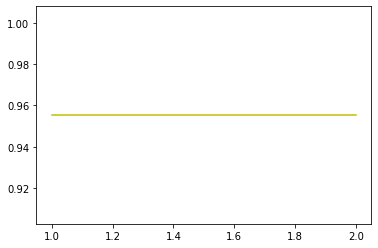

In [52]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Previous Approach Based on Survival Metadata
---

In [ ]:
def read_file(patient_id, contrast):
    filenames = [file_pattern for tumour in tumours]
    try:
        x = nib.load(filenames[0])
    except FileNotFoundError:
        x = nib.load(filenames[1])
    filenames.replace()
    nii_data = x.get_fdata()
    return nii_data

In [6]:
metadata = pd.read_csv(training_set)

In [7]:
def create_filename(row, contrast):
    possible_filenames = [file_pattern.format(prefix=prefix, tumour=tumour, patient_id=row['BraTS18ID'], contrast=contrast) for tumour in tumours]
    filename = [filename for filename in possible_filenames if os.path.exists(filename)][0]
    return filename

In [8]:
metadata['filename_flair'] = metadata.apply(create_filename, axis=1, contrast='flair')
metadata['filename_t1ce'] = metadata.apply(create_filename, axis=1, contrast='t1ce')
metadata['filename_seg'] = metadata.apply(create_filename, axis=1, contrast='seg')

In [9]:
metadata

,BraTS18ID,Age,Survival,ResectionStatus,filename_flair,filename_t1ce,filename_seg
0,Brats18_TCIA08_167_1,74.907,153,NaN,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...
1,Brats18_TCIA08_242_1,66.479,147,NaN,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...
2,Brats18_TCIA08_319_1,64.860,254,NaN,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...
3,Brats18_TCIA08_469_1,63.899,519,NaN,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...
4,Brats18_TCIA08_218_1,57.345,346,NaN,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...
...,...,...,...,...,...,...,...
158,Brats18_CBICA_ABB_1,68.493,465,GTR,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...
159,Brats18_CBICA_AAP_1,39.068,788,GTR,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...
160,Brats18_CBICA_AAL_1,54.301,464,GTR,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...
161,Brats18_CBICA_AAG_1,52.263,616,GTR,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...,/home/atom/Documents/datasets/brats/MICCAI_Bra...


# Jason's Implementation

## Load Data in Batches

In [12]:
def generate_brats_batch(file_pattern, contrasts, patient_list, batch_size=32):
    """
    Generate arrays for each batch, for x (data) and y (labels), where the contrast is treated like a colour channel.
    
    Example:
    x_batch shape: (32, 240, 240, 155, 4)
    y_batch shape: (32, 240, 240, 155)
    """
    
    keys = dict(prefix=prefix, tumour="*", patient_id="*")
    filenames = {contrast: glob.glob(file_pattern.format(contrast=contrast, **keys)) 
                 for contrast in contrasts}
    
    arbitrary_contrast = contrasts[0]
    shape = nib.load(filenames[arbitrary_contrast][0]).get_fdata().shape

    # define empty arrays for batches
    x_batch = np.empty((batch_size, ) + shape + (len(contrasts), )) #, dtype=np.int32)
    y_batch = np.empty((batch_size, ) + shape) #, dtype=np.int32)
    num_images = len(filenames[arbitrary_contrast])

    # shuffle 
    np.random.shuffle(filenames[arbitrary_contrast])

    for bindex in tqdm.tqdm_notebook(range(0, num_images, batch_size), total=num_images):
        filenames = filenames[arbitrary_contrast][bindex:bindex + batch_size]
        for findex, filename in enumerate(filenames):
            for cindex, contrast in enumerate(contrasts):
                x_batch[findex, ..., cindex] = nib.load(filename.replace(arbitrary_contrast, contrast)).get_fdata()
                y_batch[findex] = nib.load(filename.replace(arbitrary_contrast, 'seg')).get_fdata()                
        yield (x_batch, y_batch)
    

In [22]:

# train and test file holds patient ID's

# go through all batch sizes until it reaches the end of the directory 
start_batch = 0
limit = len(train_file)
end_batch = batch_size

while end_batch < limit:
    img_list = []
    mask_list = []

    file_pattern = '{prefix}/MICCAI_BraTS_2018_Data_Training/{tumour}/{patient_id}/{patient_id}_{contrast}.nii.gz'


    
    
    



In [20]:
import segmentation_models_3D as sm



Segmentation Models: using `keras` framework.


In [24]:
keys = dict(prefix=prefix, tumour="*", patient_id="*")
filenames = {contrast: glob.glob(file_pattern.format(contrast=contrast, **keys)) for contrast in contrasts}

In [25]:
filenames

{'Brats18_CBICA_ARW_1_seg.nii.gz': [],
 'Brats18_CBICA_ARW_1_flair.nii.gz': [],
 'Brats18_CBICA_ARW_1_t1.nii.gz': [],
 'Brats18_CBICA_ARW_1_t2.nii.gz': [],
 'Brats18_CBICA_ARW_1_t1ce.nii.gz': []}

In [1]:
import os

In [2]:
prefix = '/home/atom/Documents/datasets/brats'
model_loc = '/models/unet'

In [4]:
os.path.join(prefix + model_loc)

'/home/atom/Documents/datasets/brats/models/unet'